Om de training op te versnellen 

In [1]:
import os
import ctypes

# 🔐 Add CUDA DLL path for TensorFlow to load GPU libraries correctly on Windows
cuda_path = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin"
os.add_dll_directory(cuda_path)

# ✅ Attempt to load a core CUDA DLL manually (to verify it's accessible)
try:
    ctypes.WinDLL(os.path.join(cuda_path, "cudart64_110.dll"))
    print("✅ cudart64_110.dll loaded manually")
except Exception as e:
    print("❌ Failed to load cudart64_110.dll:", e)

import tensorflow as tf
tf.keras.backend.clear_session()



✅ cudart64_110.dll loaded manually


## 1) Preprocessing

In [2]:
import pandas as pd

# 100 rows is just for testing
dataset = pd.read_excel('./data/data.xlsx', nrows=100000)
english_sentences, dutch_sentences = dataset['English'].astype(str), dataset['Dutch'].astype(str)


For during training we first need to preprocess the sentences for better performance. I found out that you need to add a start and end token to the target language sentences. This so that the model can know when to start a translation and when to end it, so it never creates a sentence to long or to short.

```python
Input: "Hello, how are you?"
Target: "<start> Hallo, hoe gaat het? <end>"
```

In [3]:
def preprocess_input_sentence(sentence: str) -> str:
    return sentence.lower().strip()

def preprocess_target_sentence(sentence: str) -> str:
    return f"<start> {sentence.lower().strip()} <end>"

english_sentences = english_sentences.apply(preprocess_input_sentence)
dutch_sentences = dutch_sentences.apply(preprocess_target_sentence)

## 2) Tokenization and Padding

The model has an input layer which expects a certain amount of inputs. But not all sentences are the same lenght. So padding needs to be added to the sentences and some sentences need to be cropped.

In [4]:
english_lengths = english_sentences.str.split().apply(len)
dutch_lengths = dutch_sentences.str.split().apply(len)

# Show basic stats
print("English max length:", english_lengths.max())
print("Dutch max length:", dutch_lengths.max())
print("Recommended MAX_SEQUENCE_LENGTH (90th percentile):")
print("English:", int(english_lengths.quantile(0.90)))
print("Dutch:", int(dutch_lengths.quantile(0.90)))

English max length: 84
Dutch max length: 87
Recommended MAX_SEQUENCE_LENGTH (90th percentile):
English: 32
Dutch: 31


So 90% of all sentences are lower or equal to 32 words for both so the max sequence lenght should be about 35 just to be safe.

In [5]:
from typing import List
from tensorflow.keras.layers import TextVectorization
from tensorflow.strings import lower, regex_replace

MAX_VOCABULARY_SIZE = 15000
MAX_SEQUENCE_LENGTH = 35

def custom_standardization(input_text):
    # Lowercase and remove punctuation, but keep <start> and <end>
    lowercase = lower(input_text)
    return regex_replace(lowercase, r"[^\w\s<>]", "")

def tokenize_and_pad(sentences: List[str], max_len=MAX_SEQUENCE_LENGTH):
    vectorizer = TextVectorization(
        max_tokens=MAX_VOCABULARY_SIZE,
        output_mode='int',
        output_sequence_length=max_len,
        standardize=custom_standardization)
    
    vectorizer.adapt(sentences)
    return vectorizer(sentences), vectorizer

encoder_input_data, eng_vectorizer = tokenize_and_pad(english_sentences)
decoder_sequences, dut_vectorizer = tokenize_and_pad(dutch_sentences)


In [6]:
import numpy as np

decoder_sequences = decoder_sequences.numpy()

decoder_input_data = []
decoder_target_data = []

for sequence in decoder_sequences:
    input_sequence = sequence[:-1]      # drop <end>
    target_sequence = sequence[1:]      # drop <start>

    decoder_input_data.append(input_sequence)
    decoder_target_data.append(target_sequence)

**Why this shift is necessary:**

During training, the decoder works as follows:
1. Decoder input: Starting with `<start>` token and containing all words except the `<end>` token. This way, the decoder will never need to predict the `<end>` token as an input.

2. Decoder target: Contains all the words plus the `<end>` token, but excludes the <start> token. This ensures the model never tries to predict <start> as an output.

This shift properly aligns the input-target pairs for teacher forcing during training, where each token in the input helps predict the next token in the target translation. The model learns to generate each word based on previously generated words, and finally to generate the <end> token to properly stop the futher translation.

## 3) Creating the encoder

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout

# The total amount of dimensions the wods can have. The more dimensions the more complex realtions words can have.
EMBEDDING_DIMENSIONS = 256
LSTM_UNITS = 256

encoder_input = Input(name="encoder_input_layer", shape=(None,))
encoder_embedding = Embedding(name="encoder_embedding_layer",input_dim=MAX_VOCABULARY_SIZE, output_dim=EMBEDDING_DIMENSIONS)
encoder_embedding_output = encoder_embedding(encoder_input)
encoder_outputs, state_h, state_c = LSTM(name="encoder_lstm_layer", units=LSTM_UNITS, return_state=True, implementation=2,)(encoder_embedding_output)

`state_h` is the short term memory so the current context of what the lstm layer has read so far.

`state_c` is the long term layer about what it ha slearned so far.

Together they can summarize what the encoder understood from the english sentence. This is needed for the encoder so it has the same positional context for the dutch sentence so it wont directly translate it word by word.

## 4) Creating the decoder


In [8]:
decoder_input = Input(name="decoder_input_layer", shape=(None,))
decoder_embedding = Embedding(name="decoder_embedding_layer",input_dim=MAX_VOCABULARY_SIZE, output_dim=EMBEDDING_DIMENSIONS)
decoder_embedding_outputs = decoder_embedding(decoder_input)
decoder_lstm = LSTM(name="decoder_lstm_layer", units=LSTM_UNITS, return_sequences=True, return_state=True, dropout=0.3, implementation=2,)

decoder_outputs, _, _ = decoder_lstm(decoder_embedding_outputs, initial_state=[state_h, state_c])

# For the output layer for each word should a prediction be made with how likely that word is thats why max vocabulary size is used.
decoder_dense_layer = Dense(MAX_VOCABULARY_SIZE, activation='softmax', name="decoder_output_layer")
decoder_outputs_train = decoder_dense_layer(decoder_outputs)


In [9]:
train_model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_outputs_train)
train_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_layer (InputLaye  [(None, None)]      0           []                               
 r)                                                                                               
                                                                                                  
 decoder_input_layer (InputLaye  [(None, None)]      0           []                               
 r)                                                                                               
                                                                                                  
 encoder_embedding_layer (Embed  (None, None, 256)   3840000     ['encoder_input_layer[0][0]']    
 ding)                                                                                        

In [10]:
train_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 5) Training the model

Before the model can be trained the training set first needs to be created.

In [11]:
from tensorflow.data import Dataset, AUTOTUNE

targets = np.expand_dims(np.array(decoder_target_data), -1)

dataset = Dataset.from_tensor_slices((encoder_input_data, decoder_input_data, targets))

def format(encoder_input, decoder_input, decoder_target):
    return (encoder_input, decoder_input), decoder_target

dataset = dataset.map(format).shuffle(1024).batch(64).prefetch(AUTOTUNE)

# Split dataset: 80% train, 20% validation (by batches)
total_batches = len(dataset)
train_size = int(0.8 * total_batches)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)


I also added a callback for early stopping so it will automaticly stop when the validation loss increases.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = train_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,                
    callbacks=callbacks
)



Epoch 1/25


1250/1250 [==============================] - 60s 45ms/step - loss: 1.8605 - accuracy: 0.6756 - val_loss: 0.5593 - val_accuracy: 0.9076
Epoch 2/25
1250/1250 [==============================] - 54s 44ms/step - loss: 0.3139 - accuracy: 0.9465 - val_loss: 0.1076 - val_accuracy: 0.9846
Epoch 3/25
1250/1250 [==============================] - 54s 44ms/step - loss: 0.0912 - accuracy: 0.9874 - val_loss: 0.0445 - val_accuracy: 0.9935
Epoch 4/25
1250/1250 [==============================] - 69s 56ms/step - loss: 0.0498 - accuracy: 0.9923 - val_loss: 0.0286 - val_accuracy: 0.9951
Epoch 5/25
1250/1250 [==============================] - 71s 57ms/step - loss: 0.0359 - accuracy: 0.9937 - val_loss: 0.0227 - val_accuracy: 0.9957
Epoch 6/25
1250/1250 [==============================] - 67s 54ms/step - loss: 0.0303 - accuracy: 0.9943 - val_loss: 0.0199 - val_accuracy: 0.9960
Epoch 7/25
1250/1250 [==============================] - 66s 52ms/step - loss: 0.0266 - accuracy: 0.9947 - val_loss: 0.0179 - val_accura

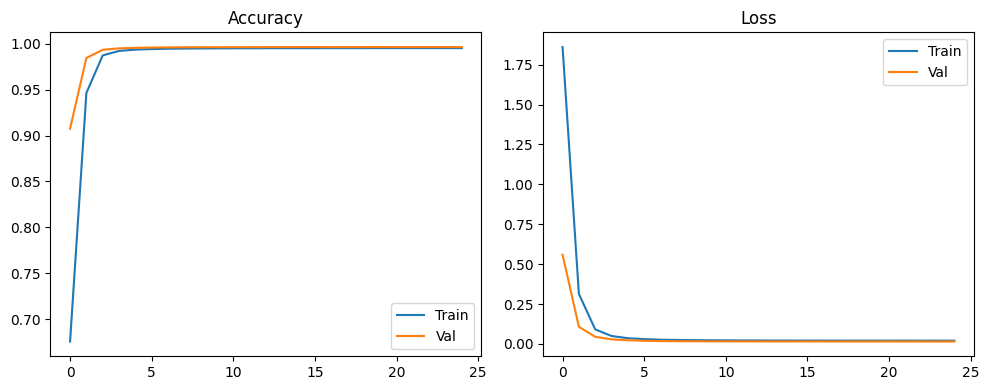

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss"); plt.legend()
plt.tight_layout()
plt.show()

As you can see the accuracy and the loss are absurd and almost not possible. This is because whats also mentioned in the book accuracy and loss are not good measures. This because its problaby good at predicting the next word in the sequence but if you predicted the wrong word last time the next word is also wrong. To test this better the blue score is calculated this one is only not build into keras so later in the notebook will i mention it.

## 6) Translating a sentence

Now that the RNN model is trained, it can’t be used for translation directly in its training form.
Why? Because during training, the model learns to predict the entire output sentence at once, using the full target sentence as input (this is called teacher forcing).

But during actual translation (inference), we don’t have the full target sentence — we have to generate it one word at a time.

To solve this, I built a separate inference model that reuses the trained layers. It takes the encoded input and the last predicted word, and predicts the next word step-by-step, until it generates the <end> token.

This process is called inference, and it's how the model performs real-time translation after training.

So first i created a new encoder model outputs the context of the english sentence to be used in the decoder.

In [14]:
encoder_model = Model(inputs=encoder_input, outputs=[state_h, state_c])

In [15]:
# We want the next word so will need to use the previous word to predict the next word.
decoder_input_infer = Input(shape=(1,),name="decoder_input_inference")
decoder_state_input_h = Input(shape=(LSTM_UNITS,), name="state_h_input")
decoder_state_input_c = Input(shape=(LSTM_UNITS,), name="state_c_input")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_emb_infer = decoder_embedding(decoder_input_infer)

decoder_outputs_infer, state_h_infer, state_c_infer = decoder_lstm(
    decoder_emb_infer, initial_state=decoder_states_inputs
)

decoder_probs = decoder_dense_layer(decoder_outputs_infer)

decoder_model = Model(
    inputs=[decoder_input_infer] + decoder_states_inputs,
    outputs=[decoder_probs, state_h_infer, state_c_infer]
)

In [16]:
decoder_model = Model(
    inputs=[decoder_input_infer] + decoder_states_inputs,
    outputs=[decoder_probs, state_h_infer, state_c_infer]
)

In [17]:
from typing import Tuple

word_index  = {
    i: word for i, word in enumerate(dut_vectorizer.get_vocabulary())
}


def translate(sentence: str) -> str:
    sentence = preprocess_input_sentence(sentence)
    input_sequence = eng_vectorizer([sentence])

    state_h, state_c = encoder_model.predict(input_sequence, verbose=0)
    start_token_id = dut_vectorizer("<start>").numpy()[0]
    end_token_id = dut_vectorizer("<end>").numpy()[0]

    decoder_input = np.array([[start_token_id]])

    translated_tokens = []

    def get_highest_prediction(predictions: Tuple) -> int:
        # predictions = (batch, time, vocab_size)
        return np.argmax(predictions[0, -1, :])
    
    def get_translated_word(word_id: int) -> str:
        return word_index.get(word_id, "?")


    for _ in range(MAX_SEQUENCE_LENGTH):
        predictions, new_state_h, new_state_c = decoder_model.predict([decoder_input, state_h, state_c], verbose=0)

        next_word_id = get_highest_prediction(predictions)

        # Check if the next word is the <end> token if so stop translation.
        if next_word_id == end_token_id:
            break;
        
        next_word = get_translated_word(next_word_id)
        translated_tokens.append(next_word)
        decoder_input = np.array([[next_word_id]])

    return " ".join(translated_tokens).capitalize() + "."



## 7) Analysis of Model Performance

### Common Issues Observed:
1. **Token Repetition**
   - The RNN model shows the same word patterns
   - This likely means the model is getting stuck in certain patterns
   - Likely due to the lack of attention mechanism

2. **Grammar and Structure**
   - The model doesn't maintain proper Dutch sentence structure
   - Word order is often incorrect
   - Missing or incorrect articles and prepositions

3. **Meaning Preservation**
   - Translations often lose the original meaning
   - The model generates plausible Dutch words but in incorrect contexts
   - This indicates the model hasn't learned the semantic relationships well

### Potential Causes:
1. **Training Data Issues**
   - Possible data quality issues in preprocessing
   - Imbalanced distribution of sentence lengths

2. **Model Architecture**
   - Lack of attention mechanism
   - Single LSTM layer might not be sufficient
   - Embedding dimensions might need adjustment

3. **Training Process**
   - Learning rate might need tuning
   - Training might need more epochs
   - Early stopping might be too aggressive

### What i would improve next:
1. **Data**
   - Improve preprocessing
   - Balance sentence length distribution

2. **Model Architecture**
   - Add attention mechanism
   - Increase LSTM layers
   - Adjust embedding dimensions

3. **Training**
   - Increase training epochs
   - Add validation metrics

## 8) Quantitative Evaluation

In [18]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt')

def calculate_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method1
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)

# Test sentences with their correct translations
test_pairs = [
    ("Hello, how are you?", "Hallo, hoe gaat het met je?"),
    ("This is my house.", "Dit is mijn huis."),
    ("Thank you for the help.", "Bedankt voor de hulp."),
    ("We are going to the beach.", "We gaan naar het strand."),
    ("I like to read books.", "Ik lees graag boeken."),
    ("Good night.", "Welterusten."),
    ("Where is the train station?", "Waar is het treinstation?"),
    ("Can you help me, please?", "Kun je me helpen, alsjeblieft?"),
    ("The weather is nice today.", "Het weer is mooi vandaag."),
    ("Let's go for a walk.", "Laten we gaan wandelen.")
]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Calculate BLEU scores

In [19]:
rnn_scores = []

for eng, dutch in test_pairs:
    rnn_translation = translate(eng)
    rnn_scores.append(calculate_bleu(dutch, rnn_translation))

print(f"RNN Average BLEU Score: {sum(rnn_scores)/len(rnn_scores):.4f}")
print("\nIndividual BLEU Scores:")
for i, (eng, dutch) in enumerate(test_pairs):
    print(f"{i+1}. {eng}")
    print(f"   Expected: {dutch}")
    print(f"   Actual: {translate(eng)}")
    print(f"   BLEU Score: {rnn_scores[i]:.4f}\n")


RNN Average BLEU Score: 0.0005

Individual BLEU Scores:
1. Hello, how are you?
   Expected: Hallo, hoe gaat het met je?
   Actual: Maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar we maar.
   BLEU Score: 0.0000

2. This is my house.
   Expected: Dit is mijn huis.
   Actual: Het eerste de efficintie en de efficintie en de efficintie en de efficintie en de efficintie en de efficintie en de efficintie en de efficintie en de efficintie en de efficintie en de efficintie en.
   BLEU Score: 0.0000

3. Thank you for the help.
   Expected: Bedankt voor de hulp.
   Actual: Het is het is het is het is het is het is het is het is het is het is het is het is het is het is het is het is het is het.
   BLEU Score: 0.0000

4. We are going to the beach.
   Expected: We gaan naar het strand.
   Actual: Het dier springt we zijn we zijn we zijn we zijn we zijn we zijn we zijn we zijn we zijn we zijn we zijn we zijn we zijn